# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [1]:
import sys
import os

# Lấy đường dẫn thư mục gốc dự án
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Thêm thư mục gốc vào sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Kiểm tra sys.path
print("Current sys.path:", sys.path)

Current sys.path: ['e:\\Estimated volume\\food_volume_estimation', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\python37.zip', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\DLLs', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib', 'c:\\Users\\anhan\\anaconda3\\envs\\T37', '', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib\\site-packages', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib\\site-packages\\win32', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib\\site-packages\\win32\\lib', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib\\site-packages\\Pythonwin', 'c:\\Users\\anhan\\anaconda3\\envs\\T37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\anhan\\.ipython', 'e:\\Estimated volume']


In [ ]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = '../models/segmentation/mask_rcnn_food_segmentation.h5'

In [ ]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

In [ ]:
%matplotlib inline

# Estimate volumes in input image
input_image = r'E:\Estimated volume\comnha.jpg'


plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

print(outputs_list)

[*] Creating intrinsics matrix from given FOV: 70
[*] Ellipse parameters: (135.4168243408203, 74.97445678710938, 80.0, 34.74747474747475, -0.02632619542114356)


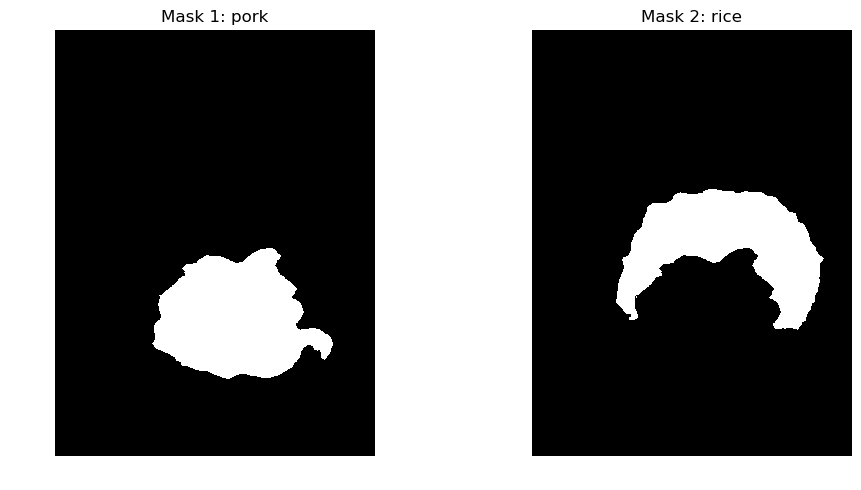

[*] Found 2 food object(s) in the image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3159419133414026, 0.03583328303030012, -0.13902151708336805, -0.9896408407170296]
[*] Estimated volume pork: 0.3820829139468549 L


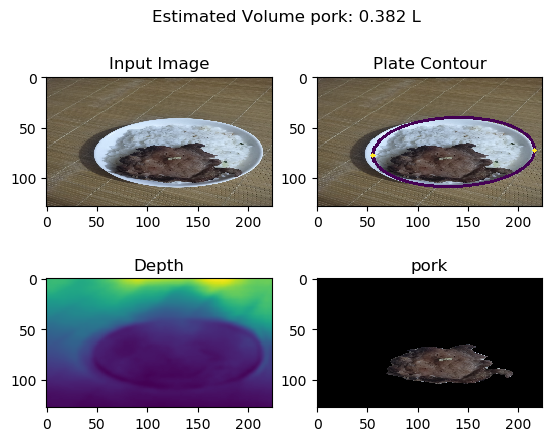

[*] Estimated plane parameters (w0,w1,w2,w3): [0.31043782229587186, 0.09450398591726374, -0.24689460308872108, -0.964423170403642]
[*] Estimated volume rice: 0.5517825410703968 L


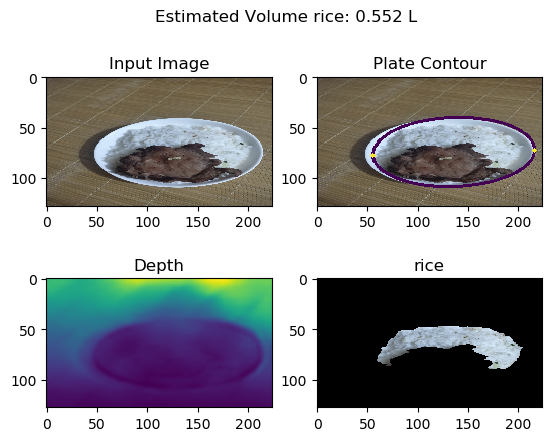

c:\Users\anhan\anaconda3\envs\T37\lib\site-packages\pythreejs\traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '
c:\Users\anhan\anaconda3\envs\T37\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.02644322533040331, 0.2726766147534363, 0.…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.06814487434115778, -0.041757139706728015, …

<Figure size 650x530 with 0 Axes>

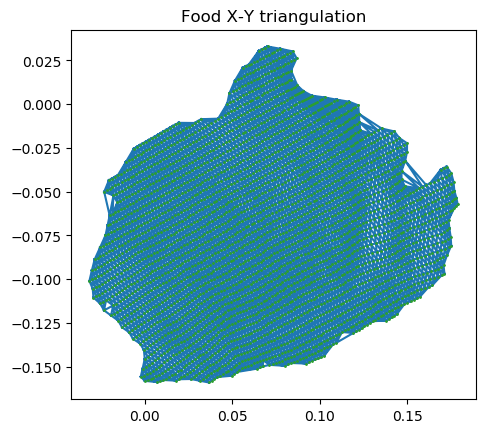

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.050068956153975344, 0.11676919733132082, …

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.03920604758440758, 0.17191392934603666, 0.…

<Figure size 650x530 with 0 Axes>

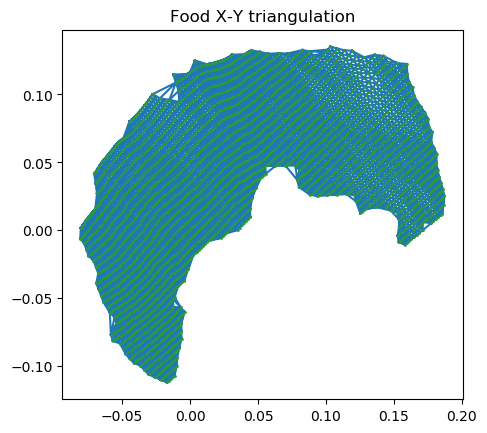

In [ ]:
# %matplotlib notebook
%matplotlib inline

# Estimate volumes in input image
# input_image = '../assets/readme_assets/examples/rice_example.jpg'
# input_image =  '../image/com_400ml_final/5.jpg'
input_image = r'E:\Estimated volume\comnha.jpg'


plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()